In [1]:
import torch
print(torch.__version__)
from math import log

2.0.0+cpu


In [2]:
D = 4
H = 8
R0 = 0.1
hidden_size = 100

In [3]:
from collections import OrderedDict

model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 1))
    ])
)
log_Z = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))
log_Z_optimizer = torch.optim.Adam([log_Z], 0.01)

In [4]:
optimizer = torch.optim.SGD(
    model.parameters(),  # Передаём все тензоры, учавствующие в градиентном спуске
    lr=0.01,  # learning rate - величина шага градиентного спуска
)

In [5]:
def right_state(state):
    global H, D
    res = []
    for i in range(0, D):
        for j in range(0, H):
            res.append(float(0) + (state[i] == j))
    return res

In [6]:
def reward(x):
    global R0, D, H
    f1 = True
    f2 = True
    for d in range(D):
        if not (0.25 < abs(x[d] / (H - 1) - 0.5) <= 0.5): f1 = False
        if not (0.3 < abs(x[d] / (H - 1) - 0.5) < 0.4): f2 = False
    return (R0 + 0.5 * f1 + 2 * f2)

In [11]:
torch.log(torch.tensor(3))

tensor(1.0986)

In [12]:
def trajectory_balance():
    global H, D, log_Z
    state = [0] * D
    way = []
    while True:
        pred = model(torch.tensor(right_state(state)))
        p_Fs = pred
        p_B = 0
        for i in range(0, D):
            if state[i] == H - 1:
                p_Fs[i] = -float("inf")
            if state[i] > 0:
                p_B += 1
        m = torch.nn.Softmax(dim=0)
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        p_B = max(p_B, 1)
        way.append([torch.log(p_Fs[ind]), 1 / p_B])
        if ind == D:
            way.append([0, 1])
            break
        state[ind] += 1
    loss = log_Z - torch.log(torch.tensor(reward(state)))
    for i in range(0, len(way) - 1):
        loss += way[i][0] - log(way[i + 1][1])
    loss = loss ** 2
    return loss, state

In [13]:
def random_way():
    global H, D
    state = [0] * D
    while True:
        pred = model(torch.tensor(right_state(state)))
        p_Fs = pred
        for i in range(0, D):
            if state[i] == H - 1:
                p_Fs[i] = -float("inf")
        m = torch.nn.Softmax(dim=0)
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        if ind == D:
            break
        state[ind] += 1
    return state

In [14]:
from itertools import product

rewards = torch.zeros(*[H for i in range(D)])
coord_diap = [range(H) for _ in range(D)]

for coord in product(*coord_diap):
    rewards[tuple(coord)] = reward(torch.tensor(coord))

rewards /= rewards.sum()

def metric(a, samples=1000):
    counter = torch.zeros(*[H for i in range(D)])
    for i in range(samples):
        counter[tuple(a[i])] += 1

    counter /= counter.sum()

    return (rewards - counter).abs().sum()

In [15]:
trajectory_balance_mem = []
detailed_balance_mem = []

In [16]:
a = []
for i in range(0, 10000):
    optimizer.zero_grad()
    log_Z_optimizer.zero_grad()
    x = trajectory_balance()
    loss = x[0]
    smpl = x[1]
    a.append(smpl)
    loss.backward()
    log_Z_optimizer.step()
    optimizer.step()
    trajectory_balance_mem.append(metric(a[-10000:], len(a[-10000:])))
    if i % 100 == 0:
        print(i)
        print(metric(a[-10000:], len(a[-10000:])))

0
tensor(1.9996)
100
tensor(1.9305)
200
tensor(1.8926)
300
tensor(1.8578)
400
tensor(1.8125)
500
tensor(1.7754)
600
tensor(1.7356)
700
tensor(1.6954)
800
tensor(1.6733)
900
tensor(1.6499)
1000
tensor(1.6337)
1100
tensor(1.6087)
1200
tensor(1.5989)
1300
tensor(1.5804)
1400
tensor(1.5575)
1500
tensor(1.5380)
1600
tensor(1.5242)
1700
tensor(1.5112)
1800
tensor(1.4959)
1900
tensor(1.4836)
2000
tensor(1.4730)
2100
tensor(1.4618)
2200
tensor(1.4495)
2300
tensor(1.4354)
2400
tensor(1.4235)
2500
tensor(1.4152)
2600
tensor(1.4049)
2700
tensor(1.3956)
2800
tensor(1.3894)
2900
tensor(1.3790)
3000
tensor(1.3689)
3100
tensor(1.3578)
3200
tensor(1.3439)
3300
tensor(1.3325)
3400
tensor(1.3215)
3500
tensor(1.3114)
3600
tensor(1.3008)
3700
tensor(1.2929)
3800
tensor(1.2827)
3900
tensor(1.2738)
4000
tensor(1.2669)
4100
tensor(1.2591)
4200
tensor(1.2501)
4300
tensor(1.2433)
4400
tensor(1.2361)
4500
tensor(1.2312)
4600
tensor(1.2246)
4700
tensor(1.2222)
4800
tensor(1.2147)
4900
tensor(1.2091)
5000
tensor(

In [17]:
def right_state(state):
    global H, D
    res = []
    for i in range(0, D):
        for j in range(0, H):
            res.append(float(0) + (state[i] == j))
    return res

In [18]:
def detailed_balance():
    global H, D
    state = [0] * D
    way = []
    while True:
        pred = model(torch.tensor(right_state(state)))
        p_Fs = pred[0:-1]
        F = pred[-1]
        p_B = 0
        for i in range(0, D):
            if state[i] == H - 1:
                p_Fs[i] = -float("inf")
            if state[i] > 0:
                p_B += 1
        m = torch.nn.Softmax(dim=0)
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        p_B = max(p_B, 1)
        way.append([F, torch.log(p_Fs[ind]), 1 / p_B])
        if ind == D:
            break
        state[ind] += 1
    loss = 0
    for i in range(0, len(way) - 1):
        loss += (way[i][0] + way[i][1] - way[i+1][0] - log(way[i + 1][2])) ** 2
    loss += (way[-1][0] + way[-1][1] - torch.log(torch.tensor(reward(state))) - log(1)) ** 2
    return loss, state

In [19]:
from collections import OrderedDict

model = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 2))
    ])
)

optimizer = torch.optim.SGD(
    model.parameters(),  # Передаём все тензоры, учавствующие в градиентном спуске
    lr=0.01,  # learning rate - величина шага градиентного спуска
)

In [20]:
a = []
for i in range(0, 10000):
    optimizer.zero_grad()
    log_Z_optimizer.zero_grad()
    x = detailed_balance()
    loss = x[0]
    smpl = x[1]
    a.append(smpl)
    loss.backward()
    log_Z_optimizer.step()
    optimizer.step()
    detailed_balance_mem.append(metric(a[-10000:], len(a[-10000:])))
    if i % 100 == 0:
        print(i)
        print(metric(a[-10000:], len(a[-10000:])))


0
tensor(1.9996)
100
tensor(1.9428)
200
tensor(1.9108)
300
tensor(1.8708)
400
tensor(1.8317)
500
tensor(1.7860)
600
tensor(1.7421)
700
tensor(1.6969)
800
tensor(1.6593)
900
tensor(1.6229)
1000
tensor(1.5895)
1100
tensor(1.5601)
1200
tensor(1.5382)
1300
tensor(1.5063)
1400
tensor(1.4809)
1500
tensor(1.4548)
1600
tensor(1.4333)
1700
tensor(1.4103)
1800
tensor(1.3865)
1900
tensor(1.3674)
2000
tensor(1.3488)
2100
tensor(1.3287)
2200
tensor(1.3044)
2300
tensor(1.2866)
2400
tensor(1.2685)
2500
tensor(1.2483)
2600
tensor(1.2338)
2700
tensor(1.2204)
2800
tensor(1.2050)
2900
tensor(1.1905)
3000
tensor(1.1735)
3100
tensor(1.1619)
3200
tensor(1.1450)
3300
tensor(1.1308)
3400
tensor(1.1165)
3500
tensor(1.0991)
3600
tensor(1.0814)
3700
tensor(1.0673)
3800
tensor(1.0511)
3900
tensor(1.0367)
4000
tensor(1.0246)
4100
tensor(1.0113)
4200
tensor(0.9961)
4300
tensor(0.9825)
4400
tensor(0.9693)
4500
tensor(0.9573)
4600
tensor(0.9435)
4700
tensor(0.9294)
4800
tensor(0.9178)
4900
tensor(0.9051)
5000
tensor(

In [21]:
import matplotlib.pyplot as plt

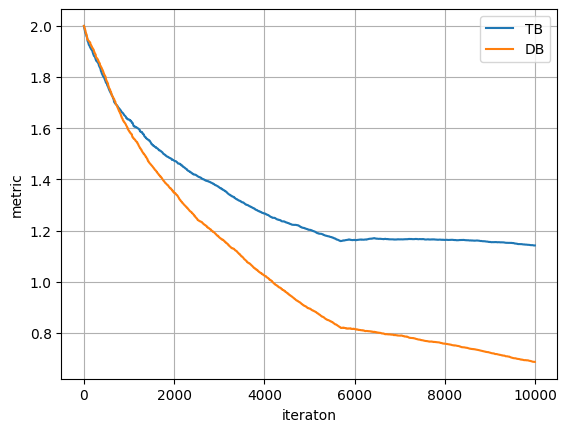

In [22]:
plt.plot(trajectory_balance_mem)
plt.plot(detailed_balance_mem)
plt.grid(True)
plt.legend(['TB', 'DB'])
plt.xlabel('iteraton')
plt.ylabel('metric')
plt.show()